# Нормализация признаков с помощью графовых сверточных сетей

In [1]:
#!pip install -q torch-scatter~=2.1.0 torch-sparse~=0.6.16 torch-cluster~=1.6.0 torch-spline-conv~=1.2.1 torch-geometric==2.2.0 -f https://data.pyg.org/whl/torch-{torch.__version__}.html

In [2]:
import numpy as np

D = np.array([
    [3, 0, 0, 0],
    [0, 1, 0, 0],
    [0, 0, 2, 0],
    [0, 0, 0, 2]
])

In [3]:
np.linalg.inv(D)

array([[0.33333333, 0.        , 0.        , 0.        ],
       [0.        , 1.        , 0.        , 0.        ],
       [0.        , 0.        , 0.5       , 0.        ],
       [0.        , 0.        , 0.        , 0.5       ]])

In [4]:
np.linalg.inv(D + np.identity(4))

array([[0.25      , 0.        , 0.        , 0.        ],
       [0.        , 0.5       , 0.        , 0.        ],
       [0.        , 0.        , 0.33333333, 0.        ],
       [0.        , 0.        , 0.        , 0.33333333]])

In [5]:
A = np.array([
    [1, 1, 1, 1],
    [1, 1, 0, 0],
    [1, 0, 1, 1],
    [1, 0, 1, 1]
])

print(np.linalg.inv(D + np.identity(4)) @ A)
print()
print(A @ np.linalg.inv(D + np.identity(4)))

[[0.25       0.25       0.25       0.25      ]
 [0.5        0.5        0.         0.        ]
 [0.33333333 0.         0.33333333 0.33333333]
 [0.33333333 0.         0.33333333 0.33333333]]

[[0.25       0.5        0.33333333 0.33333333]
 [0.25       0.5        0.         0.        ]
 [0.25       0.         0.33333333 0.33333333]
 [0.25       0.         0.33333333 0.33333333]]


Processing...
Done!


<BarContainer object of 37 artists>

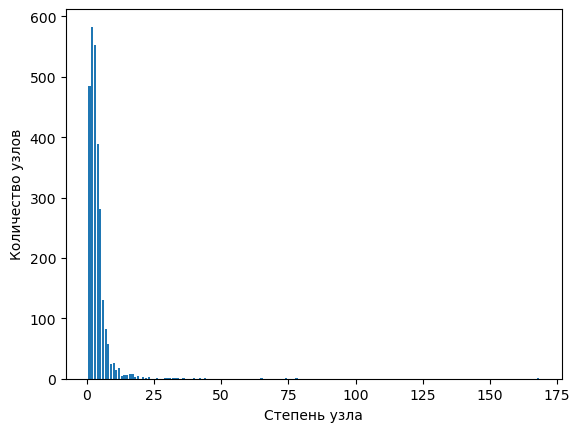

In [6]:
from torch_geometric.datasets import Planetoid
from torch_geometric.utils import degree
from collections import Counter
import matplotlib.pyplot as plt

# импортируем набор данных из PyTorch Geometric
dataset = Planetoid(root=".", name="Cora")
data = dataset[0]

# получаем список степеней
degrees = degree(data.edge_index[0]).numpy()

# вычисляем количество узлов для каждой степени
numbers = Counter(degrees)

# столбиковая диаграмма
fig, ax = plt.subplots()
ax.set_xlabel('Степень узла')
ax.set_ylabel('Количество узлов')
plt.bar(numbers.keys(), numbers.values())

Processing...
Done!


<BarContainer object of 233 artists>

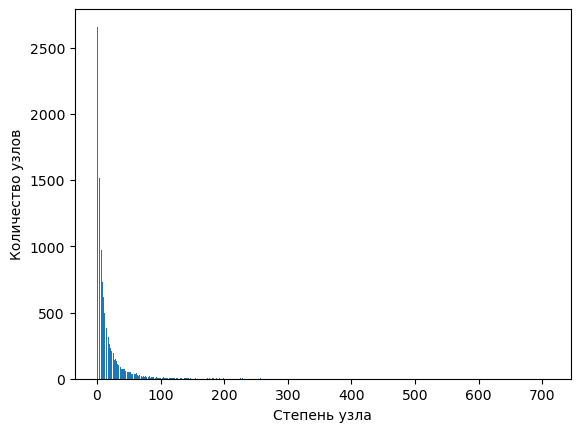

In [7]:
from torch_geometric.datasets import FacebookPagePage

# импортируем набор данных из PyTorch Geometric
dataset = FacebookPagePage(root=".")
data = dataset[0]

# создаем маски
data.train_mask = range(18000)
data.val_mask = range(18001, 20000)
data.test_mask = range(20001, 22470)

# создаем список степеней
degrees = degree(data.edge_index[0]).numpy()

# вычисляем количество узлов для каждой степени
numbers = Counter(degrees)

# столбиковая диаграмма
fig, ax = plt.subplots()
ax.set_xlabel('Степень узла')
ax.set_ylabel('Количество узлов')
plt.bar(numbers.keys(), numbers.values())

In [8]:
import torch
torch.manual_seed(1)
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

dataset = Planetoid(root=".", name="Cora")
data = dataset[0]

def accuracy(y_pred, y_true):
    """Вычисляет правильность."""
    return torch.sum(y_pred == y_true) / len(y_true)


class GCN(torch.nn.Module):
    """Графовая сверточная нейросеть"""
    def __init__(self, dim_in, dim_h, dim_out):
        super().__init__()
        self.gcn1 = GCNConv(dim_in, dim_h)
        self.gcn2 = GCNConv(dim_h, dim_out)

    def forward(self, x, edge_index):
        h = self.gcn1(x, edge_index)
        h = torch.relu(h)
        h = self.gcn2(h, edge_index)
        return F.log_softmax(h, dim=1)

    def fit(self, data, epochs):
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(self.parameters(),
                                     lr=0.01,
                                     weight_decay=5e-4)

        self.train()
        for epoch in range(epochs+1):
            optimizer.zero_grad()
            out = self(data.x, data.edge_index)
            loss = criterion(out[data.train_mask], data.y[data.train_mask])
            acc = accuracy(out[data.train_mask].argmax(dim=1),
                          data.y[data.train_mask])
            loss.backward()
            optimizer.step()

            if(epoch % 20 == 0):
                val_loss = criterion(out[data.val_mask], data.y[data.val_mask])
                val_acc = accuracy(out[data.val_mask].argmax(dim=1),
                                  data.y[data.val_mask])
                print(f'Эпоха {epoch:>3}:\n| Функция потерь на обуч. выборке: '
                      f'{loss:.3f} | Правильность на обуч. выборке: '
                      f'{acc*100:>5.2f}% \n| Функция потерь на валид. '
                      f'выборке: {val_loss:.2f} | Правильность на валид. '
                      f'выборке: {val_acc*100:.2f}%')

    @torch.no_grad()
    def test(self, data):
        self.eval()
        out = self(data.x, data.edge_index)
        acc = accuracy(out.argmax(dim=1)[data.test_mask], 
                       data.y[data.test_mask])
        return acc

# создаем модель GCN
gcn = GCN(dataset.num_features, 16, dataset.num_classes)
print(gcn)

# обучаем
gcn.fit(data, epochs=100)

# тестируем
cora_gcn_acc = gcn.test(data)
print(f'\nПравильность GCN на тесте (Cora): {cora_gcn_acc*100:.2f}%\n')

GCN(
  (gcn1): GCNConv(1433, 16)
  (gcn2): GCNConv(16, 7)
)
Эпоха   0:
| Функция потерь на обуч. выборке: 1.932 | Правильность на обуч. выборке: 15.71% 
| Функция потерь на валид. выборке: 1.94 | Правильность на валид. выборке: 15.20%
Эпоха  20:
| Функция потерь на обуч. выборке: 0.099 | Правильность на обуч. выборке: 100.00% 
| Функция потерь на валид. выборке: 0.75 | Правильность на валид. выборке: 77.80%
Эпоха  40:
| Функция потерь на обуч. выборке: 0.014 | Правильность на обуч. выборке: 100.00% 
| Функция потерь на валид. выборке: 0.72 | Правильность на валид. выборке: 77.20%
Эпоха  60:
| Функция потерь на обуч. выборке: 0.015 | Правильность на обуч. выборке: 100.00% 
| Функция потерь на валид. выборке: 0.71 | Правильность на валид. выборке: 77.80%
Эпоха  80:
| Функция потерь на обуч. выборке: 0.017 | Правильность на обуч. выборке: 100.00% 
| Функция потерь на валид. выборке: 0.71 | Правильность на валид. выборке: 77.00%
Эпоха 100:
| Функция потерь на обуч. выборке: 0.016 | Правиль

In [9]:
# импортируем набор данных из PyTorch Geometric
dataset = FacebookPagePage(root=".")
data = dataset[0]
data.train_mask = range(18000)
data.val_mask = range(18001, 20000)
data.test_mask = range(20001, 22470)

# создаем модель GCN
gcn = GCN(dataset.num_features, 16, dataset.num_classes)
print(gcn)

# обучаем
gcn.fit(data, epochs=100)

# тестируем
fb_gcn_acc = gcn.test(data)
print(f'\nПравильность GCN на тесте (Facebook): {fb_gcn_acc*100:.2f}%\n')

GCN(
  (gcn1): GCNConv(128, 16)
  (gcn2): GCNConv(16, 4)
)
Эпоха   0:
| Функция потерь на обуч. выборке: 1.463 | Правильность на обуч. выборке: 20.72% 
| Функция потерь на валид. выборке: 1.45 | Правильность на валид. выборке: 20.71%
Эпоха  20:
| Функция потерь на обуч. выборке: 0.443 | Правильность на обуч. выборке: 84.64% 
| Функция потерь на валид. выборке: 0.43 | Правильность на валид. выборке: 85.29%
Эпоха  40:
| Функция потерь на обуч. выборке: 0.323 | Правильность на обуч. выборке: 89.59% 
| Функция потерь на валид. выборке: 0.31 | Правильность на валид. выборке: 90.20%
Эпоха  60:
| Функция потерь на обуч. выборке: 0.278 | Правильность на обуч. выборке: 91.36% 
| Функция потерь на валид. выборке: 0.27 | Правильность на валид. выборке: 91.55%
Эпоха  80:
| Функция потерь на обуч. выборке: 0.254 | Правильность на обуч. выборке: 92.28% 
| Функция потерь на валид. выборке: 0.26 | Правильность на валид. выборке: 92.75%
Эпоха 100:
| Функция потерь на обуч. выборке: 0.238 | Правильность

In [10]:
from torch_geometric.datasets import WikipediaNetwork
import torch_geometric.transforms as T

dataset = WikipediaNetwork(
    root=".", name="chameleon", 
    transform=T.RandomNodeSplit(num_val=200, num_test=500)
)
data = dataset[0]

# печатаем информацию о наборе данных
print(f'Набор данных: {dataset}')
print('---------------')
print(f'Количество графов: {len(dataset)}')
print(f'Количество узлов: {data.x.shape[0]}')
print(f'Количество признаков: {dataset.num_features}')
print(f'Количество классов: {dataset.num_classes}')

# печатаем информацию о графе
print(f'\nГраф:')
print('------')
print(f'Ребра являются ориентированными: {data.is_directed()}')
print(f'У графа есть изолированные узлы: {data.has_isolated_nodes()}')
print(f'У графа есть петли: {data.has_self_loops()}')

Processing...


Набор данных: WikipediaNetwork()
---------------
Количество графов: 1
Количество узлов: 2277
Количество признаков: 2325
Количество классов: 5

Граф:
------
Ребра являются ориентированными: True
У графа есть изолированные узлы: False
У графа есть петли: True


Done!


In [11]:
from io import BytesIO
from urllib.request import urlopen
from zipfile import ZipFile

url = 'https://snap.stanford.edu/data/wikipedia.zip'
with urlopen(url) as zurl:
    with ZipFile(BytesIO(zurl.read())) as zfile:
        zfile.extractall('.')

In [12]:
import pandas as pd

df = pd.read_csv('wikipedia/chameleon/musae_chameleon_target.csv')
values = np.log10(df['target'])
data.y = torch.tensor(values)
data.y

tensor([2.2330, 3.9079, 3.9329,  ..., 1.9956, 4.3598, 2.4409],
       dtype=torch.float64)

<BarContainer object of 63 artists>

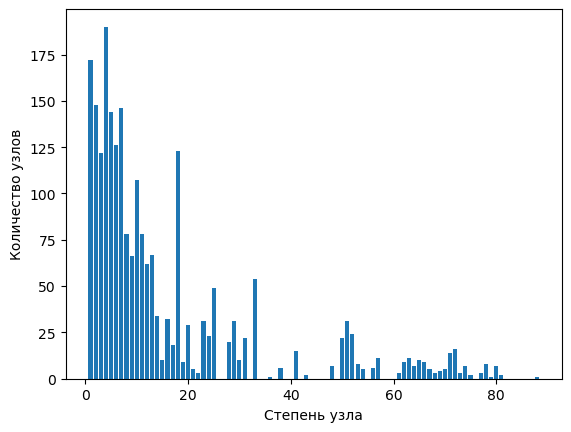

In [13]:
# получаем список степеней
degrees = degree(data.edge_index[0]).numpy()

# вычисляем количество узлов для каждой степени
numbers = Counter(degrees)

# столбиковая диаграмма
fig, ax = plt.subplots()
ax.set_xlabel('Степень узла')
ax.set_ylabel('Количество узлов')
plt.bar(numbers.keys(), numbers.values())

/Users/artemgruzdev/anaconda3/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


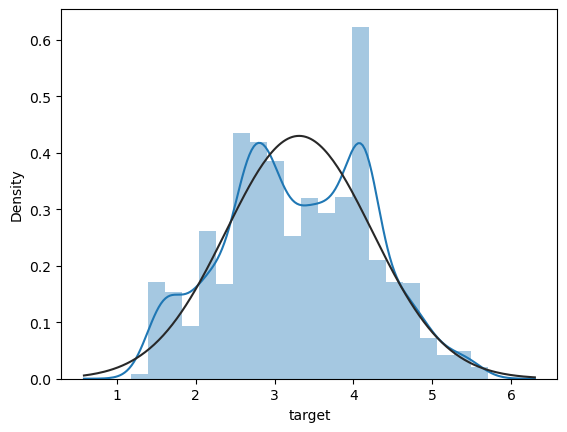

In [14]:
import seaborn as sns
from scipy.stats import norm

df['target'] = values
fig = sns.distplot(df['target'], fit=norm)

In [15]:
class GCN(torch.nn.Module):
    """Графовая сверточная сеть"""
    def __init__(self, dim_in, dim_h, dim_out):
        super().__init__()
        self.gcn1 = GCNConv(dim_in, dim_h*4)
        self.gcn2 = GCNConv(dim_h*4, dim_h*2)
        self.gcn3 = GCNConv(dim_h*2, dim_h)
        self.linear = torch.nn.Linear(dim_h, dim_out)

    def forward(self, x, edge_index):
        h = self.gcn1(x, edge_index)
        h = torch.relu(h)
        h = F.dropout(h, p=0.5, training=self.training)
        h = self.gcn2(h, edge_index)
        h = torch.relu(h)
        h = F.dropout(h, p=0.5, training=self.training)
        h = self.gcn3(h, edge_index)
        h = torch.relu(h)
        h = self.linear(h)
        return h

    def fit(self, data, epochs): 
        optimizer = torch.optim.Adam(self.parameters(),
                                      lr=0.02,
                                      weight_decay=5e-4)

        self.train()
        for epoch in range(epochs+1):
            optimizer.zero_grad()
            out = self(data.x, data.edge_index)
            loss = F.mse_loss(out.squeeze()[data.train_mask], 
                              data.y[data.train_mask].float())
            loss.backward()
            optimizer.step()
            if epoch % 20 == 0:
                val_loss = F.mse_loss(out.squeeze()[data.val_mask], 
                                      data.y[data.val_mask])
                
                print(f"Эпоха {epoch:>3}:\n| Функция потерь на обуч. выборке: "
                      f"{loss:.5f} | Функция потерь на валид. выборке: "
                      f"{val_loss:.5f}")

    def test(self, data):
        self.eval()
        out = self(data.x, data.edge_index)
        return F.mse_loss(out.squeeze()[data.test_mask], 
                          data.y[data.test_mask].float())

# создаем модель GCN
gcn = GCN(dataset.num_features, 128, 1)
print(gcn) 

# обучаем
gcn.fit(data, epochs=200)

# тестируем
loss = gcn.test(data)
print(f'\nФункция потерь модели GCN на тесте: {loss:.5f}\n')

GCN(
  (gcn1): GCNConv(2325, 512)
  (gcn2): GCNConv(512, 256)
  (gcn3): GCNConv(256, 128)
  (linear): Linear(in_features=128, out_features=1, bias=True)
)
Эпоха   0:
| Функция потерь на обуч. выборке: 12.81936 | Функция потерь на валид. выборке: 13.00659
Эпоха  20:
| Функция потерь на обуч. выборке: 11.71822 | Функция потерь на валид. выборке: 11.76676
Эпоха  40:
| Функция потерь на обуч. выборке: 10.29417 | Функция потерь на валид. выборке: 10.34435
Эпоха  60:
| Функция потерь на обуч. выборке: 8.67988 | Функция потерь на валид. выборке: 8.72097
Эпоха  80:
| Функция потерь на обуч. выборке: 4.03177 | Функция потерь на валид. выборке: 4.00314
Эпоха 100:
| Функция потерь на обуч. выборке: 1.94211 | Функция потерь на валид. выборке: 2.00301
Эпоха 120:
| Функция потерь на обуч. выборке: 0.97431 | Функция потерь на валид. выборке: 1.10884
Эпоха 140:
| Функция потерь на обуч. выборке: 0.73444 | Функция потерь на валид. выборке: 0.89813
Эпоха 160:
| Функция потерь на обуч. выборке: 0.59117 |

In [16]:
from sklearn.metrics import (mean_squared_error, 
                             mean_absolute_error)

out = gcn(data.x, data.edge_index)
y_pred = out.squeeze()[data.test_mask].detach().numpy()
mse = mean_squared_error(data.y[data.test_mask], y_pred)
mae = mean_absolute_error(data.y[data.test_mask], y_pred)

print('=' * 43)
print(f'MSE = {mse:.4f} | RMSE = {np.sqrt(mse):.4f} | MAE = {mae:.4f}')
print('=' * 43)

MSE = 0.7210 | RMSE = 0.8491 | MAE = 0.6828


[Text(0.5, 0, 'Фактические значения'),
 Text(0, 0.5, 'Спрогнозированные значения')]

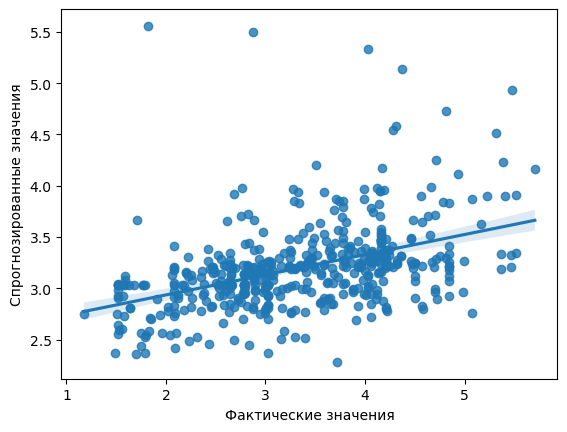

In [17]:
fig = sns.regplot(x=data.y[data.test_mask].numpy(), y=y_pred)
fig.set(xlabel='Фактические значения', 
        ylabel='Спрогнозированные значения')